In [1]:
import numpy as np
import pandas as pd
import argparse
import json
import pickle
import os
import numba
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow import keras as kr
import tensorflow.keras.optimizers as opt

#import model layers
from tensorflow.keras.layers import Layer,Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Conv2DTranspose, Reshape, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1_l2      
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#import QKeras as qkr
from qkeras import QDense, QConv2D, QActivation
import json

import ot
import uproot
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema

2023-02-16 12:45:14.570361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from load_utils import load_data, normalize, unnormalize

In [3]:
data_values, eta_values = load_data(infile = '/Users/physics/hep/ex/code/Ecoder/5Elinks_data.csv',nrows = 1000)

(1000, 48)


In [4]:
# measure TC occupancy
occupancy_all = np.count_nonzero(data_values,axis=1) # measure non-zero TCs (should be all)
occupancy_all_1MT = np.count_nonzero(data_values>35,axis=1) # measure TCs with charge > 35

# normalize input charge data
# rescaleInputToMax: normalizes charges to maximum charge in module
# sumlog2 (default): normalizes charges to 2**floor(log2(sum of charge in module)) where floor is the largest scalar integer: i.e. normalizes to MSB of the sum of charges (MSB here is the most significant bit)
# rescaleSum: normalizes charges to sum of charge in module
normdata,maxdata,sumdata = normalize(data_values.copy(),sumlog2=True)
maxdata = maxdata / 35. # normalize to units of transverse MIPs
sumdata = sumdata / 35. # normalize to units of transverse MIPs

In [5]:
networks_by_name = [
    {'name':'8x8_c8_S2_qK_RTL_emd_lphe',
     'label':'8x8_c[8]_S2_q_emd_lphe',
     'arr_key':'8x8',
     'isQK':True,
     'params':{
         'shape':(8,8,1),
         'loss':'',
         'CNN_layer_nodes':[8],
         'CNN_kernel_size':[3],
         'CNN_strides':[(2,2)],
        },
    }
]

In [6]:
def build_model():

    # select models to run
    
    m_to_run = ['8x8_c8_S2_qK_RTL_tele','8x8_c8_S2_qK_RTL_emd_lphe']
    models = [n for n in networks_by_name if n['name'] in m_to_run]

        
    nBits_encod = dict()
    nBits_encod  = {'total':  9, 'integer': 1,'keep_negative':0} # 0 to 2 range, 8 bit decimal 
    nBits_input  = {'total': 10, 'integer': 3, 'keep_negative':1}
    nBits_accum  = {'total': 11, 'integer': 3, 'keep_negative':1}
    nBits_weight = {'total':  5, 'integer': 1, 'keep_negative':1} # sign bit not included
    
    for m in models:
        if not 'nBits_encod' in m['params'].keys():
            m['params'].update({'nBits_encod':nBits_encod})
            m['params'].update({'nBits_input':nBits_input})
            m['params'].update({'nBits_accum':nBits_accum})
            m['params'].update({'nBits_weight':nBits_weight})
            
    for m in models:
        # print nbits for qkeras
        if m['isQK']:
            print('qKeras model weight {total}, {integer}, {keep_negative}'.format(**m['params']['nBits_weight']))
            print('qKeras model input {total}, {integer}, {keep_negative}'.format(**m['params']['nBits_input']))
            print('qKeras model accum {total}, {integer}, {keep_negative}'.format(**m['params']['nBits_accum']))
            print('qKeras model encod {total}, {integer}, {keep_negative}'.format(**m['params']['nBits_encod']))
             
    return models

In [7]:
models = build_model()

qKeras model weight 5, 1, 1
qKeras model input 10, 3, 1
qKeras model accum 11, 3, 1
qKeras model encod 9, 1, 0


In [8]:
!pwd

/Users/physics/hep/ex/code/Ecoder


In [9]:
orig_dir = os.getcwd()
if not os.path.exists('save_cmssw'): os.mkdir('save_cmssw')
os.chdir('save_cmssw')

In [10]:
!pwd

/Users/physics/hep/ex/code/Ecoder/save_cmssw


In [11]:
class MaskLayer(Layer):
    def __init__(self,nFilter,arrMask):
        super(MaskLayer, self).__init__()
        self.nFilter = tf.constant(nFilter)
        self.arrayMask = np.array([arrMask])
        self.mask = tf.reshape(tf.stack(
                        tf.repeat(self.arrayMask,repeats=[nFilter],axis=0),axis=1),
                        shape=[-1])      
    def call(self, inputs):
        return tf.reshape(tf.boolean_mask(inputs,self.mask,axis=1),
                          shape=(tf.shape(inputs)[0],48*self.nFilter))
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'nFilter': self.nFilter.numpy(),
            'arrMask': self.arrayMask.tolist(),
        })
        return config

In [12]:
arrange =  np.array([28,29,30,31,0,4,8,12,
                     24,25,26,27,1,5,9,13,
                     20,21,22,23,2,6,10,14,
                     16,17,18,19,3,7,11,15,
                     47,43,39,35,35,34,33,32,
                     46,42,38,34,39,38,37,36,
                     45,41,37,33,43,42,41,40,
                     44,40,36,32,47,46,45,44])

arrMask= np.array([1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,])
    
calQMask=np.array([1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,])


In [13]:
def prepInput(normData):
    
    shape = (8,8,1)
    inputdata = normData[:,arrange]

    inputdata[:,arrMask==0]=0  #zeros out repeated entries

    shaped_data = inputdata.reshape(len(inputdata),shape[0],shape[1],shape[2])
    
    return shaped_data

In [14]:
remap_8x8 = [4, 12, 20, 28,  5, 13, 21, 29,  6, 14, 22, 30,  7, 15, 23, 31, 
             24, 25, 26, 27, 16, 17, 18, 19,  8,  9, 10, 11,  0,  1,  2,  3, 
             59, 51, 43, 35, 58, 50, 42, 34, 57, 49, 41, 33, 56, 48, 40, 32]

arrange443 = np.array([0,16, 32,
                       1,17, 33,
                       2,18, 34,
                       3,19, 35,
                       4,20, 36,
                       5,21, 37,
                       6,22, 38,
                       7,23, 39,
                       8,24, 40,
                       9,25, 41,
                       10,26, 42,
                       11,27, 43,
                       12,28, 44,
                       13,29, 45,
                       14,30, 46,
                       15,31, 47])



In [15]:
model_path='/Users/physics/hep/ex/code/Ecoder/ae_mse_lphe.h5'
emd_model = tf.keras.models.load_model(model_path)
emd_model.trainable = False

def map_881_to_443(x):
    y = tf.reshape(x, (-1, 64))
    y = tf.gather(y, remap_8x8, axis=1)
    y = tf.gather(y, arrange443, axis=1)
    y = tf.reshape(y, (-1, 4, 4, 3))
    return y

2023-02-16 12:45:20.504267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
shaped_data = prepInput(normdata)

def split(shaped_data, validation_frac=0.2,randomize=False):
    N = round(len(shaped_data)*validation_frac)
    if randomize:
        val_index = np.random.choice(shaped_data.shape[0], N, replace=False) # randomly select 25% entries
        full_index = np.array(range(0,len(shaped_data))) # select the indices of the other 75%
        train_index = np.logical_not(np.in1d(full_index,val_index))

        val_input = shaped_data[val_index]
        train_input = shaped_data[train_index]
    else:
        val_input = shaped_data[:N]
        train_input = shaped_data[N:]
        val_index = np.arange(N)
        train_index = np.arange(len(shaped_data))[N:]

    print('Training shape')
    print(train_input.shape)
    print('Validation shape')
    print(val_input.shape)
    return val_input,train_input,val_index,train_index

val_input, train_input, val_ind, train_ind = split(shaped_data)

train_sum = sumdata[train_ind]
val_sum = sumdata[val_ind]

Training shape
(800, 8, 8, 1)
Validation shape
(200, 8, 8, 1)


In [17]:
train_sum = sumdata[train_ind]
val_sum = sumdata[val_ind]

train_eta = eta_values[train_ind]
val_eta = eta_values[val_ind]

In [18]:
encoded_dim = 16

CNN_layer_nodes   = [8]
CNN_kernel_size   = [3]
CNN_padding       = ['same']
CNN_strides       = [(2,2)]
CNN_pool          = [False]
Dense_layer_nodes = [] #does not include encoded layer
channels_first    = False

In [19]:
def emd_loss(y_true_cal,y_pred_cal):
    
    y_pred_443 = map_881_to_443(y_pred_cal)
    y_true_443 = map_881_to_443(y_true_cal)
    return emd_model([y_true_443, y_pred_443])

In [20]:
def GetQbits(inp, keep_negative=1):
    print("Setting bits {} {} with keep negative = {}".format(inp['total'], inp['integer'], keep_negative))
    b =  qkr.quantized_bits(bits=inp['total'], integer=inp['integer'], keep_negative=keep_negative, alpha=1)
    print('max = %s, min = %s'%(b.max(),b.min()))
    print('str representation:%s'%(str(b)))
    print('config = ',b.get_config())
    return b

In [21]:
nBits_encod  = {'total':  9, 'integer': 1,'keep_negative':0} # 0 to 2 range, 8 bit decimal 
nBits_input  = {'total': 10, 'integer': 3, 'keep_negative':1}
nBits_accum  = {'total': 11, 'integer': 3, 'keep_negative':1}
nBits_weight = {'total':  5, 'integer': 1, 'keep_negative':1} # sign bit not included

In [22]:
import qkeras as qkr

In [23]:
input_Qbits  = GetQbits(nBits_input, nBits_input['keep_negative']) 
accum_Qbits  = GetQbits(nBits_accum, nBits_accum['keep_negative'])
qa_accum     = qkr.quantized_relu(bits=nBits_accum['total'],integer=nBits_accum['integer'])
dense_Qbits  = GetQbits(nBits_weight, nBits_weight['keep_negative'])
conv_Qbits   = GetQbits(nBits_weight , nBits_weight ['keep_negative'])
encod_Qbits  = GetQbits(nBits_encod, nBits_encod['keep_negative'])
qa_encod    = qkr.quantized_relu(bits = nBits_encod['total'],integer=nBits_encod['integer'])

Setting bits 10 3 with keep negative = 1
max = 8.0, min = -8.0
str representation:quantized_bits(10,3,0,alpha=1)
config =  {'bits': 10, 'integer': 3, 'symmetric': 0, 'alpha': 1, 'keep_negative': 1, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0}
Setting bits 11 3 with keep negative = 1
max = 8.0, min = -8.0
str representation:quantized_bits(11,3,0,alpha=1)
config =  {'bits': 11, 'integer': 3, 'symmetric': 0, 'alpha': 1, 'keep_negative': 1, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0}
Setting bits 5 1 with keep negative = 1
max = 2.0, min = -2.0
str representation:quantized_bits(5,1,0,alpha=1)
config =  {'bits': 5, 'integer': 1, 'symmetric': 0, 'alpha': 1, 'keep_negative': 1, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0}
Setting bits 5 1 with keep negative = 1
max = 2.0, min = -2.0
str representation:quantized_bits(5,1,0,alpha=1)
config =  {'bits': 5, 'integer': 1, 'symmetric': 0, 'alpha': 1, 'keep_negative': 1, 'use_stochastic_rounding': False, 'qnoise_fact

In [24]:
inputs = [Input(shape=(8,8,1)),
          Input(shape = (1)),
          Input(shape = (1))]

x = inputs[0]

x = QActivation(input_Qbits, name='input_qa')(x)

for i,n_nodes in enumerate(CNN_layer_nodes):

    x = QConv2D(n_nodes, CNN_kernel_size[i], padding=CNN_padding[i], name="conv2d_"+str(i)+"_m", 
                strides = CNN_strides[i], kernel_quantizer=conv_Qbits, bias_quantizer=conv_Qbits)(x)
shape = K.int_shape(x)
x = QActivation(qa_accum, name='accum1_qa')(x)
x = Flatten(name="flatten")(x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Add sum_tc and eta_tc as inputs

In [25]:
from tensorflow.keras.layers import Concatenate

In [26]:
concat =  Concatenate(axis=1)([x,inputs[1],inputs[2]])

In [27]:
encodedLayer = QDense(encoded_dim, name='encoded_vector',
           kernel_quantizer=dense_Qbits, bias_quantizer=dense_Qbits)(concat)

In [27]:
#encodedLayer = QActivation(16, name='encod_qa')(x)

In [28]:
# Instantiate Encoder Model
encoder = Model(inputs, encodedLayer, name='encoder')

encoded_inputs = Input(shape=(encoded_dim,), name='decoder_input')

In [29]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 input_qa (QActivation)         (None, 8, 8, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv2d_0_m (QConv2D)           (None, 4, 4, 8)      80          ['input_qa[0][0]']               
                                                                                                  
 accum1_qa (QActivation)        (None, 4, 4, 8)      0           ['conv2d_0_m[0][0]']             
                                                                                            

In [30]:
x = encoded_inputs

#decoder dense nodes

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i,n_nodes in enumerate(CNN_layer_nodes):

    x = Conv2DTranspose(n_nodes, CNN_kernel_size[i], activation='relu', strides=CNN_strides[i],padding=CNN_padding[i])(x)

x = Conv2DTranspose(filters=(8,8,1)[2],kernel_size=CNN_kernel_size[0],padding='same')(x)

outputs= Activation('sigmoid', name='decoder_output')(x)

decoder = Model(encoded_inputs, outputs, name='decoder')

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

In [31]:
autoencoder.compile(optimizer='adam', loss=emd_loss)

In [32]:
train_sum_t = tf.expand_dims(train_sum,axis=1)
train_eta_t = tf.expand_dims(train_eta,axis=1)

In [33]:
val_sum_t = tf.expand_dims(val_sum,axis=1)
val_eta_t = tf.expand_dims(val_eta,axis=1)

In [34]:
n_epochs=100

es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = autoencoder.fit([train_input,train_sum_t,train_eta_t],
                          train_input,
                          epochs=n_epochs,
                          batch_size=50,
                          validation_data=([val_input,val_sum_t,val_eta_t],val_input),
                          callbacks=[es])

Epoch 1/100
16/16 [==============================] - 3s 60ms/step - loss: 36.4911 - val_loss: 33.8216
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 29.2945 - val_loss: 23.1874
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 16.4813 - val_loss: 10.5811
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 6.5852 - val_loss: 5.1862
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 5.0655 - val_loss: 5.1333
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 5.0359 - val_loss: 5.1314
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 5.0315 - val_loss: 5.1302
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 5.0293 - val_loss: 5.1290
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 5.0279 - val_loss: 5.1283
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 5.0266 - val_loss: 

16/16 [==============================] - 0s 11ms/step - loss: 3.1466 - val_loss: 3.2738
Epoch 83/100
16/16 [==============================] - 0s 11ms/step - loss: 3.1223 - val_loss: 3.2554
Epoch 84/100
16/16 [==============================] - 0s 11ms/step - loss: 3.1398 - val_loss: 3.3086
Epoch 85/100
16/16 [==============================] - 0s 11ms/step - loss: 3.0945 - val_loss: 3.2202
Epoch 86/100
16/16 [==============================] - 0s 11ms/step - loss: 3.0741 - val_loss: 3.2081
Epoch 87/100
16/16 [==============================] - 0s 11ms/step - loss: 3.0357 - val_loss: 3.1445
Epoch 88/100
16/16 [==============================] - 0s 11ms/step - loss: 3.0046 - val_loss: 3.1645
Epoch 89/100
16/16 [==============================] - 0s 11ms/step - loss: 2.9668 - val_loss: 3.1053
Epoch 90/100
16/16 [==============================] - 0s 11ms/step - loss: 2.9310 - val_loss: 3.0726
Epoch 91/100
16/16 [==============================] - 0s 11ms/step - loss: 2.8965 - val_loss: 3.0560
Epo

In [35]:
def plot_loss(history):
    plt.figure(figsize=(8,6))
    plt.yscale('log')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.savefig("history.pdf")
    plt.show()
    plt.close()
    plt.clf()
    return

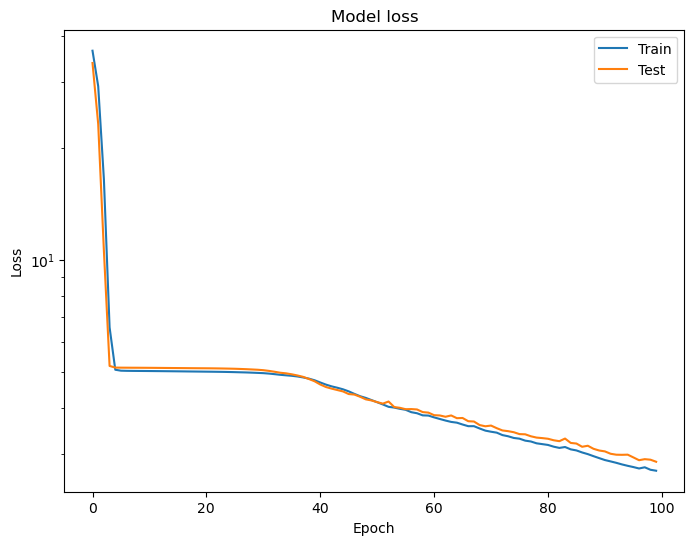

<Figure size 640x480 with 0 Axes>

In [36]:
plot_loss(history)

In [37]:
def invertArrange(arrange,arrMask=[],calQMask=[]):
    remap =[]
    hashmap = {}  ## cell:index mapping
    ##Valid arrange check
    if not np.all(np.unique(arrange)==np.arange(48)):
        raise ValueError("Found cell location with number > 48. Please check your arrange:",arrange)
    foundDuplicateCharge = False
    if len(arrMask)==0:
        if len(arrange)>len(np.unique(arrange)):
            foundDuplicateCharge=True
    else:
        if len(arrange[arrMask==1])>len(np.unique(arrange[arrMask==1])):
            foundDuplicateCharge=True

    if foundDuplicateCharge and len(calQMask)==0:
        raise ValueError("Found duplicated charge arrangement, but did not specify calQmask")  
    if len(calQMask)>0 and np.count_nonzero(calQMask)!=48:
        raise ValueError("calQmask must indicate 48 calQ ")  

    for i in range(len(arrange)):
        if len(arrMask)>0 :
            ## fill hashmap only if arrMask allows it
            if arrMask[i]==1:   
                if(foundDuplicateCharge):
                    ## fill hashmap only if calQMask allows it
                    if calQMask[i]==1: hashmap[arrange[i]]=i                    
                else:
                    hashmap[arrange[i]]=i                    
        else:
            hashmap[arrange[i]]=i
    ## Always map to 48 calQ orders
    for i in range(len(np.unique(arrange))):
        remap.append(hashmap[i])
    return np.array(remap)

## remap input/output of autoencoder into CALQs orders
def mapToCalQ(x):
    if len(arrange) > 0:
        remap   = invertArrange(arrange,arrMask,calQMask)
        if len(arrMask)>0:
            imgSize =(8,8,1)[0] *(8,8,1)[1]* (8,8,1)[2]
            x = x.reshape(len(x),imgSize)
            x[:,arrMask==0]=0 ## apply arrMask
            return x[:,remap]             ## map to calQ 
        else:
            return x.reshape(len(x),48)[:,remap]
    else:
        return x.reshape(len(x),48)


def predict(x):
    decoded_Q = predict(x)
    encoded_Q = self.encoder.predict(x)
    encoded_Q = np.reshape(encoded_Q, (len(encoded_Q), 16, 1))
    return x,decoded_Q, encoded_Q

In [38]:
history = autoencoder.history

In [39]:
cnn_deQ = autoencoder.predict([shaped_data,sumdata,eta_values])

32/32 [==============================] - 0s 2ms/step


In [40]:
# shape = (N,48) in CALQ order
input_calQ = mapToCalQ(shaped_data)
output_calQ = mapToCalQ(cnn_deQ)   # shape = (N,48) in CALQ order
print('inputQ shape')
print(input_calQ.shape)
print('inputcalQ shape')
print(output_calQ.shape)

inputQ shape
(1000, 48)
inputcalQ shape
(1000, 48)


In [41]:
val_max = maxdata[val_ind]
val_sum = sumdata[val_ind]
val_eta = eta_values[val_ind]

In [42]:
print('Restore normalization')

input_calQ =  unnormalize(input_calQ.copy(),sumdata)
output_calQ =  unnormalize(output_calQ.copy(),sumdata)

Restore normalization


# Plot normdata

In [43]:
normdata.shape

(1000, 48)

In [44]:
norm = pd.DataFrame(normdata)

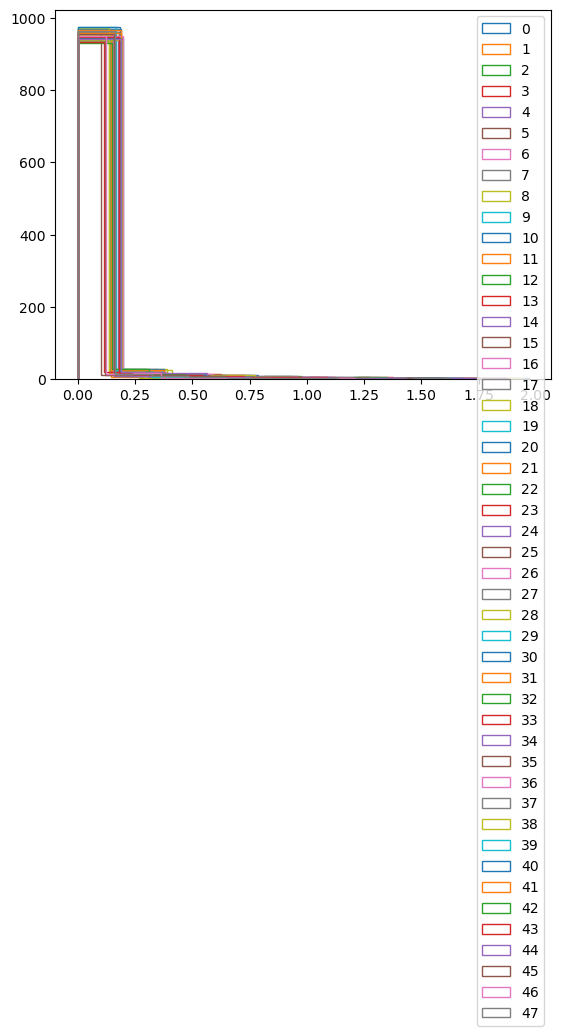

In [45]:
for i in range(48):
    plt.hist(norm[i],label = '{}'.format(i),histtype='step')
#plt.xlim(0.001,1.25)
#plt.yscale('log')
plt.legend()

In [46]:
from utils.metrics import emd

In [47]:
indices = range(0,(len(input_calQ)))
        
emd_values = np.array([emd(input_calQ[i],output_calQ[j]) for i, j in zip(indices,indices)])

In [48]:
import scipy

from scipy import stats, optimize, interpolate

(array([ 12.,  95., 200., 256., 233., 142.,  39.,  15.,   7.,   1.]),
 array([0.45017802, 0.87784539, 1.30551277, 1.73318015, 2.16084752,
        2.5885149 , 3.01618228, 3.44384965, 3.87151703, 4.29918441,
        4.72685178]),
 <BarContainer object of 10 artists>)

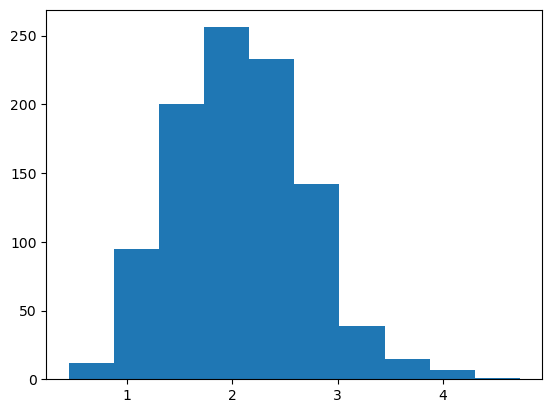

In [49]:
plt.hist(emd_values)

<ErrorbarContainer object of 3 artists>

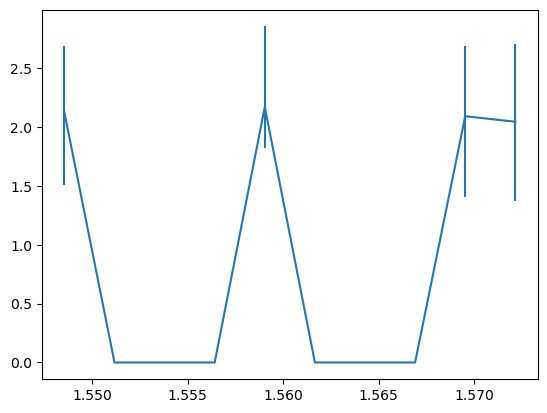

In [50]:
x=eta_values
y=emd_values

nbins=10
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie], label='emd v eta')

<ErrorbarContainer object of 3 artists>

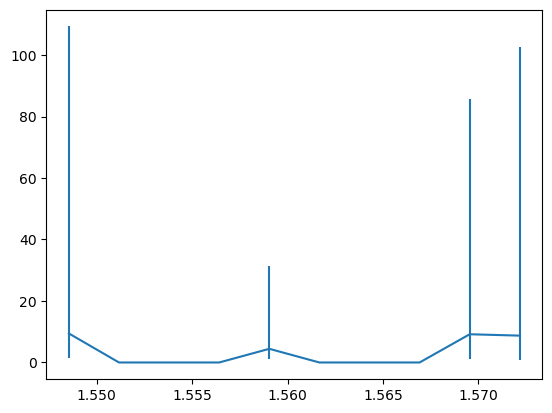

In [51]:
x=eta_values
y=emd_values*sumdata*sumdata

nbins=10
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie], label='emd v eta')

In [52]:
occupancy_0MT = np.count_nonzero(input_calQ,axis=1)

<ErrorbarContainer object of 3 artists>

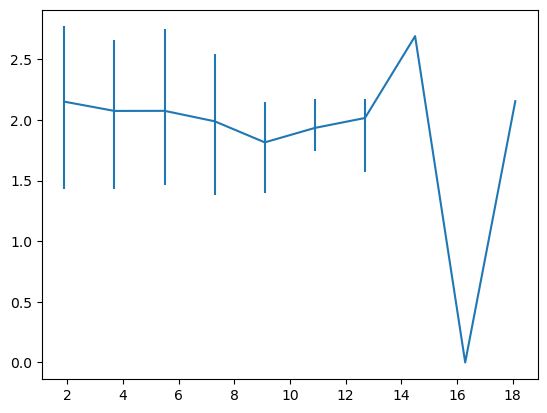

In [53]:
x=occupancy_0MT
y=emd_values

nbins=10
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie], label='emd v eta')

In [54]:
with open('./history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [57]:
from qkeras.utils import model_save_quantized_weights

In [60]:
name = 'extra_inputs'

In [61]:
from utils import graph

json_string = autoencoder.to_json()
encoder = autoencoder.get_layer("encoder")
decoder = autoencoder.get_layer("decoder")
with open('./%s.json'%name,'w') as f:        f.write(autoencoder.to_json())
with open('./%s.json'%("encoder_"+name),'w') as f:            f.write(encoder.to_json())
with open('./%s.json'%("decoder_"+name),'w') as f:            f.write(decoder.to_json())
autoencoder.save_weights('%s.hdf5'%name)
encoder.save_weights('%s.hdf5'%("encoder_"+name))
decoder.save_weights('%s.hdf5'%("decoder_"+name))

In [62]:
encoder_qWeight = model_save_quantized_weights(encoder)
with open('encoder_'+name+'.pkl','wb') as f:
    pickle.dump(encoder_qWeight,f)
encoder = graph.set_quantized_weights(encoder,'encoder_'+name+'.pkl')

... quantizing model


In [151]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [155]:
def write_frozen_graph_encoder(model,outputName="frozen_graph.pb",logdir='./',asText=False):
    full_model = tf.function(lambda x: model(x))
    full_model = full_model.get_concrete_function(
        x=[tf.TensorSpec(shape = model.inputs[0].shape,dtype=tf.float32),
   tf.TensorSpec(shape = model.inputs[1].shape,dtype=tf.float32),
   tf.TensorSpec(shape = model.inputs[2].shape,dtype=tf.float32)])

    frozen_func = convert_variables_to_constants_v2(full_model)
    frozen_func.graph.as_graph_def()

    layers = [op.name for op in frozen_func.graph.get_operations()]

    # Save frozen graph from frozen ConcreteFunction to hard drive
    tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                      logdir=logdir,
                      name=outputName,
                      as_text=asText)

In [156]:
def write_frozen_graph_decoder(model,outputName="frozen_graph.pb",logdir='./',asText=False):
    full_model = tf.function(lambda x: model(x))
    full_model = full_model.get_concrete_function(
        x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    frozen_func = convert_variables_to_constants_v2(full_model)
    frozen_func.graph.as_graph_def()

    layers = [op.name for op in frozen_func.graph.get_operations()]

    # Save frozen graph from frozen ConcreteFunction to hard drive
    tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                      logdir=logdir,
                      name=outputName,
                      as_text=asText)

In [157]:
write_frozen_graph_encoder(encoder,'encoder_'+name+'.pb')
write_frozen_graph_encoder(encoder,'encoder_'+name+'.pb.ascii','./',True)

2023-02-16 13:45:46.720979: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-02-16 13:45:46.721060: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-16 13:45:47.168704: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-02-16 13:45:47.168779: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [158]:
write_frozen_graph_decoder(decoder,'decoder_'+name+'.pb')
write_frozen_graph_decoder(decoder,'decoder_'+name+'.pb.ascii','./',True)

2023-02-16 13:46:03.519575: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-02-16 13:46:03.519678: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-16 13:46:03.696243: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-02-16 13:46:03.696308: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
